In [30]:
%matplotlib inline

In [31]:
import matplotlib.pyplot as plt

import torch
from sklearn.metrics import confusion_matrix

import numpy as np

import torch.nn as nn

from tqdm import tqdm_notebook

from torchvision import transforms
from torchvision import datasets
from os.path import join

from deepsith import DeepSITH

from tqdm.notebook import tqdm

import random

from csv import DictWriter
# if gpu is to be used
use_cuda = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor

ttype =FloatTensor

import seaborn as sn
print(use_cuda)
import pickle

sn.set_context("poster")

True


In [32]:
class DeepSITH_Classifier(nn.Module):
    def __init__(self, out_features, layer_params, dropout=.1):
        super(DeepSITH_Classifier, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out_features)
    def forward(self, inp):
        x = self.hs(inp)
        x = self.to_out(x)
        return x

In [33]:
import scipy.optimize as opt
from deepsith import iSITH
def min_fun(x, *args):
    ntau = int(x[0])
    k = int(x[1])
    if k < 4 or k>125:
        return np.inf
    tau_min = args[0]
    tau_max = args[1]    
    ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*5, k=k, ntau=ntau, dt=1, g=1.0)    
    std_0 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1)[int(tau_min):int(tau_max)].std()
    std_1 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1)[int(tau_min):int(tau_max)].std()    
    to_min = std_0/std_1
    return to_min

# Load Stimuli

In [34]:
norm = transforms.Normalize((.1307,), (.3081,), )

In [35]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((.1307,), (.3081,))
                               ])
ds1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
ds2 = datasets.MNIST('../data', train=False, download=True, transform=transform)
train_loader=torch.utils.data.DataLoader(ds1,batch_size=batch_size, 
                                         num_workers=1, pin_memory=True, shuffle=True)
test_loader=torch.utils.data.DataLoader(ds2, batch_size=batch_size, 
                                        num_workers=1, pin_memory=True, shuffle=True)

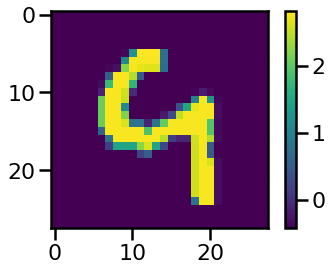

In [36]:
test = next(iter(test_loader))[0]

plt.imshow(test[0].reshape(-1).reshape(28,28))

plt.colorbar()

# Define test and train

In [37]:

def train(model, ttype, train_loader, test_loader, optimizer, loss_func, epoch, perf_file,
          loss_buffer_size=800, batch_size=4, device='cuda',
          prog_bar=None):
    
    assert(loss_buffer_size%batch_size==0)

        
    losses = []
    perfs = []
    last_test_perf = 0
    best_test_perf = -1
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data = data.to(device).view(data.shape[0],1,1,-1)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_func(out[:, -1, :],
                         target)

        loss.backward()
        optimizer.step()

        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      target).sum().item())
        perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        losses = losses[int(-loss_buffer_size/batch_size):]
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.4f}, perf: {:.4f}, valid: {:.4f}"
            format_list = [e,batch_idx*batch_size, np.mean(losses), 
                           np.sum(perfs)/((len(perfs))*batch_size), last_test_perf]         
            s = s.format(*format_list)
            prog_bar.set_description(s)
        
        if ((batch_idx*batch_size)%loss_buffer_size == 0) & (batch_idx != 0):
            loss_track = {}
            last_test_perf = test(model, 'cuda', test_loader, 
                                  batch_size=batch_size, 
                                  )
            loss_track['avg_loss'] = np.mean(losses)
            loss_track['last_test'] = last_test_perf
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            loss_track['train_perf']= np.sum(perfs)/((len(perfs))*batch_size)
            with open(perf_file, 'a+') as fp:
                csv_writer = DictWriter(fp, fieldnames=list(loss_track.keys()))
                if fp.tell() == 0:
                    csv_writer.writeheader()
                csv_writer.writerow(loss_track)
                fp.flush()
            if best_test_perf < last_test_perf:
                torch.save(model.state_dict(), perf_file[:-4]+".pt")
                best_test_perf = last_test_perf

                
def test(model, device, test_loader, batch_size=4):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device).view(data.shape[0],1,1,-1)
            target = target.to(device)
            
            out = model(data)
            pred = out[:, -1].argmax(dim=-1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += 1
    return correct / len(test_loader.dataset)

# Setup the model

/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)
/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


   direc: array([[1., 0.],
       [0., 1.]])
     fun: 0.19828296
 message: 'Optimization terminated successfully.'
    nfev: 170
     nit: 3
  status: 0
 success: True
       x: array([8.10044045, 4.4488778 ])
ntau: 8 k: 4


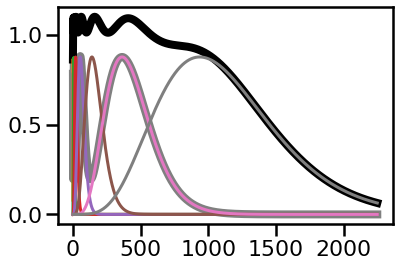

In [38]:
ntau_0 = 5
k_0 = 20
tau_min = 1.
tau_max = 750.
res = opt.minimize(min_fun, [ntau_0, k_0], args=(tau_min, tau_max), 
                   #method='Nelder-Mead',
                   method='Powell',
                   #method='L-BFGS-B',
                   #method='BFGS',
                   #method='CG',
                   #method='TNC',
                   bounds=[(5, 50), (4, 125)]
                  )
print(res)
ntau = int(res.x[0])
k = int(res.x[1])
print('ntau:', ntau, 'k:', k)
ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*3, k=k, ntau=ntau, dt=1.0, g=1.0)
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1),
        linewidth=8, color='grey');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        linewidth=8, color='black');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );

In [54]:
g = 0.0
sith_params1 = {"in_features":1, 
                "tau_min":1, "tau_max":30.0, "buff_max":50,
                "k":73, 'dt':1,
                "ntau":15, 'g':g,  
                "ttype":ttype, "batch_norm":True,
                "hidden_size":50, "act_func":nn.ReLU()
               }
sith_params2 = {"in_features":sith_params1['hidden_size'], 
                "tau_min":1, "tau_max":150.0, "buff_max":275,
                "k":33, 'dt':1,
                "ntau":15, 'g':g, 
                "ttype":ttype, "batch_norm":True,
                "hidden_size":50, "act_func":nn.ReLU()
                }
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":1, "tau_max":750.0, "buff_max":1500,
                "k":19, 'dt':1,
                "ntau":15, 'g':g, 
                "ttype":ttype, "batch_norm":True,
                "hidden_size":50, "act_func":nn.ReLU()
                }
layer_params = [sith_params1, sith_params2, sith_params3]


model = DeepSITH_Classifier(10,
                           layer_params=layer_params, 
                           dropout=0.2).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 76710
DeepSITH_Classifier(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=15, tau_min=1, tau_max=30.0, buff_max=50, dt=1, k=73, g=0.0)
        (linear): Linear(in_features=15, out_features=50, bias=True)
        (act_func): ReLU()
        (dense_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=15, tau_min=1, tau_max=150.0, buff_max=275, dt=1, k=33, g=0.0)
        (linear): Linear(in_features=750, out_features=50, bias=True)
        (act_func): ReLU()
        (dense_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): _DeepSITH_core(
        (sith): iSITH(ntau=15, tau_min=1, tau_max=750.0, buff_max=1500, dt=1, k=19, g=0.0)
        (linear): Linear(in_features=750, out_features=50, bias=True)
        (act_func): ReLU()
        (dense_bn): BatchNorm1d(50, eps=1e-05, momentum=0.

# Verify the iSITH filters

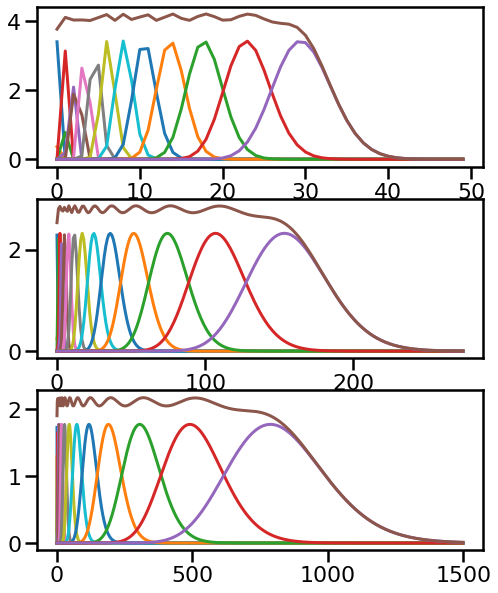

In [53]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(3,1,1)
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,2)
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,3)
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );

In [40]:
32*64

2048

In [ ]:
epochs = 80
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for e in progress_bar:
    train(model, ttype, train_loader, test_loader, optimizer, loss_func, batch_size=batch_size,
          epoch=e, perf_file=join('perf','smnist_deepsith_5.csv'),loss_buffer_size=64*32, 
          prog_bar=progress_bar)

# Find Errors

In [220]:
def conf_mat_gen(model, device, test_loader, batch_size=4, permute=None):
    if permute is None:
        permute = torch.LongTensor(list(range(784)))
    evals = {'pred':[],
             'actual':[]}
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device).view(data.shape[0],1,1,-1)
            target = target.to(device)
            for x in target:
                evals['actual'].append(x.detach().cpu().numpy())
            out = model(data[:,:,:, permute])
            for x in out[:, -1].argmax(dim=-1, keepdim=True):
                evals['pred'].append(x.detach().cpu().numpy())
    return evals

In [221]:
evals = conf_mat_gen(model, 'cuda', test_loader, batch_size=4, permute=permute)

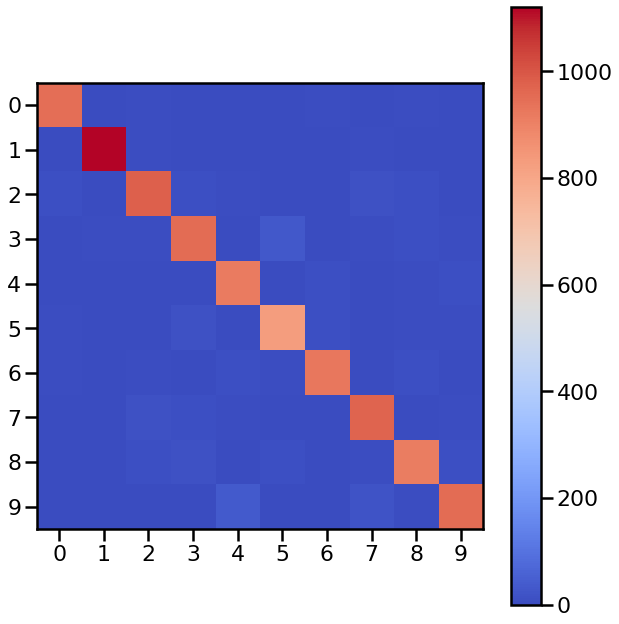

In [227]:
fig = plt.figure(figsize=(10,11))
plt.imshow(confusion_matrix(np.array(evals['pred'])[:, 0], 
                            np.array(evals['actual'])), cmap='coolwarm')
plt.colorbar()
plt.xticks(list(range(10)));
plt.yticks(list(range(10)));
plt.savefig(join('figs', 'sMNIST_LoLa_conf'), dpi=200, bboxinches='tight')